# **Ferminet Tutorial**

Author : Shaipranesh S : [Website](https://shaipranesh.vercel.app/)


**Background:**
---
  The electrons in a molecule are quantum mechanical in nature, meaning they do not follow classical physical laws. Quantum mechanics only gives a probability of where the electrons will be found and will not tell exactly where it can be found. This probability is given by the squared magnitude of a property of molecule system called the wavefunction and is different in each case of different molecule.

For many purposes, the nuclei of the atoms in a molecule can be considered to be stationary, and then we solve to get the wavefunction of the electrons. The probabilites when modelled into 3 dimensional space, takes the shape of the orbitals. Like shown in these images below which is taken via electron microscope.

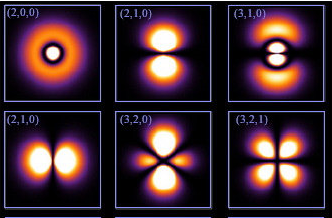
*(From the top left, oribtals in order - 2s, 2p(y),3p(y),2p(x),3d(z^2),3d(x^2-y^2))*


Don't worry if you cannot remember or relate to the concept of orbitals, just remember that these are the space where electrons are found with more probability.

Using these wavefunctions, the electronic structure(a model containing electrons at its most probable positions) of a system can be obtained which can be used to calculate the energy at ground state. This value, then can be used to calculate various properties like ionization energy, electron affinity, etc.

The wavefunction of simple one electron systems like hydrogen atom, helium cation can be found easily, but for heavier atoms and molecules, electron-electron repulsion comes into act and makes it hard to compute the wavefunctions due to these interactions. Calculating these wavefunctions exactly will need a lot of computing resources and time which cannot be feasible to get them. Hence, other various different techniques for to approximate the wavefunction have been introduced, where there is a different tradeoff between speed and accuracy of the solution. One such method is the variational Monte Carlo which aims to include the effects of electron correlation in the solution without it.

Since Deep learning act as universal function approximators, it can be used to approximate wavefunction as well!! One such approach is the DNN based Variational Monte Carlo called [Ferminet](https://arxiv.org/pdf/1909.02487.pdf). In this tutorial we will be looking into how to use Ferminet to find out the ionization potential of a molecule.



**Variational Monte Carlo**

VMC is a Monte carlo based method based on the variational principle in quantum mechanics. The variational principle states that the expected value of the energy of a trial wave function is always greater than or equal to the ground state energy of the molecule system:-

 							E0≤⟨ψ|H|ψ⟩.

Hence the traditional VMC aims to sample the electron’s coordinates via Monte Carlo techniques and move towards such values which minimizes the expected energy of the trial wave function.

Steps:-

1. Begin by initializing both the energy and electron coordinate values. Commence the Monte Carlo calculation.


2. Compute a trial position.


3. Employ the Metropolis algorithm to determine whether to accept or reject the proposed new move.


4. If the step is accepted, update the parameters.
Update running averages.


5. Conclude the calculation and compute the final averages after a set number of steps.


By this method, we can approximate the ground state energies of molecular systems. However the results heavily depend on the quality of the trial wavefunction, and the optimization of these functions is an area of active research.
Deep learning techniques can help to approximate and optimize the trial wave functions with physics-based elements built into the ansatz, and the cost as the expected energy function.


# **Colab**
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/FermiNet_DeepChem_tutorial.ipynb)


**Ferminet Architecture details overview**:-

Ferminet has “L” number of 1-electron and 2-electron feature layers which acts as the embedding layer for electron distance features.
It models the ansatz as an “envelope layer” which takes in the calculated 1-electron features from the embedding layers as the input. The basic idea of the envelope is to enforce the condition that the wave function reaches close to 0 as the distance of the electron tends to infinity.

Ferminet expresses the wave function as a Slater type orbital where the multi-electron wavefunctions are the envelope functions calculated. The determinant product of all the orbitals gives the trial-wavefunction sampled.

For  more information on our implementation of FermiNet and the new heurestics for ions as input, checkout out our paper: https://arxiv.org/abs/2401.10287

**Ferminet training:**


Ferminet has 2 parts to the training - supervised pre-training and unsupervised ansatz optimization w.r.t expected energy as the cost function.
In the pretraining, orbital values calculated from Hartree-Fock method are used as the label which the ferminet’s orbital values will match up to. Here the loss is simply the Mean squared error between the ferminet and Hartree Fock orbital values. By this method, we train the ferminet to learn an ansatz which will match Hartree-Fock baseline.
Then in the actual training, the model is tuned in accordance with expected energy cost function, and the model actually learns to better include the electron interactions which were missing in the original Hartree-Fock solution, thereby increasing the quality of the trial-wave function and sampling better electrons that reduce the expected energy more, simultaneously.


In this tutorial we will look into calculating the ground state energy of the H2 molecule using the FermiNet model implementation in Deepchem.

In [2]:
!pip install --pre deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.5/999.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.2 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.8 MB/s eta 0:00:00


In [4]:
!pip install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 16.3 MB/s eta 0:00:00


#  Initialization & Pretraining of FermiNet

FermiNet requires the only input of a list of lists containing the nucleon's coordinates.

The format is `[['Element Symbol',[3D coordinates]],[...],...]`

In [9]:
from deepchem.models.torch_models.ferminet import FerminetModel
import torch

In [24]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Initializing the H2 molecule's coordinates
H2_molecule = [['H', [0, 0, 0]],['H', [0, 0, 1.4135151]]]
# Initializing the FermiNet model (spin:0, charge: 0,, batch:4 - more the number of batches accurate the solution gets)
mol = FerminetModel(H2_molecule, spin=0, ion_charge=0, batch_no=4)
# pretraining of the model initially
mol.train(nb_epoch=150)

converged SCF energy = -1.11628637177674  <S^2> = 2.220446e-16  2S+1 = 1
 ** Mulliken pop alpha/beta on meta-lowdin orthogonal AOs **
 ** Mulliken pop       alpha | beta **
pop of  0 H 1s        0.50000 | 0.50000   
pop of  1 H 1s        0.50000 | 0.50000   
In total             1.00000 | 1.00000   
 ** Mulliken atomic charges   ( Nelec_alpha | Nelec_beta ) **
charge of  0H =      0.00000  (     0.50000      0.50000 )
charge of  1H =      0.00000  (     0.50000      0.50000 )
converged SCF energy = -1.11628637177674  <S^2> = 2.220446e-16  2S+1 = 1


/usr/local/lib/python3.10/dist-packages/deepchem/models/torch_models/layers.py:5657: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  self.wdet.append(torch.nn.init.normal(torch.zeros(1)).squeeze(0))
/usr/local/lib/python3.10/dist-packages/deepchem/models/torch_models/layers.py:5660: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  (torch.nn.init.normal(torch.zeros(n_one[-1], 1),) /
/usr/local/lib/python3.10/dist-packages/deepchem/models/torch_models/layers.py:5663: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  (torch.nn.init.normal(torch.zeros(1))).squeeze(0))
/usr/local/lib/python3.10/dist-packages/pyscf/gto/mole.py:1280: UserWarning: Function mol.dumps drops attribute spin because it is not JSON-serializable
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1, 1])) that is different to the input size (torc

The loss for the pretraining iteration 0 is 0.02710416354238987
The loss for the pretraining iteration 1 is 0.02550419606268406
The loss for the pretraining iteration 2 is 0.014827233739197254
The loss for the pretraining iteration 3 is 0.010277194902300835
The loss for the pretraining iteration 4 is 0.012760447338223457
The loss for the pretraining iteration 5 is 0.008348378352820873
The loss for the pretraining iteration 6 is 0.004029400181025267
The loss for the pretraining iteration 7 is 0.004069587681442499
The loss for the pretraining iteration 8 is 0.006711069494485855
The loss for the pretraining iteration 9 is 0.006214166060090065
The loss for the pretraining iteration 10 is 0.0034270230680704117
The loss for the pretraining iteration 11 is 0.0018716256599873304
The loss for the pretraining iteration 12 is 0.0025977646000683308
The loss for the pretraining iteration 13 is 0.0038076299242675304
The loss for the pretraining iteration 14 is 0.0035712781827896833
The loss for the 

Now, let's try to calculate and print the enrgy after pretraining manually by calling the functions in the model and using the result from passing the input to the network.

In [25]:
mol.model.forward(torch.from_numpy(mol.molecule.x))
energy = mol.model.calculate_electron_electron(
) - mol.model.calculate_electron_nuclear(
) + mol.model.nuclear_nuclear_potential + mol.model.calculate_kinetic_energy(
)
mean_energy = torch.mean(energy)
print("the energy before start")
print(mean_energy)

the energy before start
tensor(-1.2601, dtype=torch.float64)


You can see that the value closely matches that of the HF ground state energy after pretrain, as you can see in the output logs of the pretraining. This sets the model in a better starting postition than from starting to traing from scratch.

# Training of FermiNet

Before the actual training begins, we will have to call the 'prepare_train' function for the MCMC burn-in and to re-initialize the electron's positions. Then we call in the train function to begine the training of FermiNet.

In [26]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

mol.prepare_train()
mol.train(nb_epoch=100, lr=0.0002, std=0.04)

The mean energy for the training iteration 0 is -1.2023134152304877
The mean energy for the training iteration 1 is -1.2212279380372484
The mean energy for the training iteration 2 is -1.22077931653164
The mean energy for the training iteration 3 is -1.214419004496566
The mean energy for the training iteration 4 is -1.174576947039055
The mean energy for the training iteration 5 is -1.1390901910542182
The mean energy for the training iteration 6 is -1.0899969485517154
The mean energy for the training iteration 7 is -1.0565436788181055
The mean energy for the training iteration 8 is -1.064048258001718
The mean energy for the training iteration 9 is -1.0608130317570892
The mean energy for the training iteration 10 is -1.1026921930114093
The mean energy for the training iteration 11 is -1.066838369414313
The mean energy for the training iteration 12 is -1.0981637181819963
The mean energy for the training iteration 13 is -1.208385874402916
The mean energy for the training iteration 14 is -1

Access the final_energy attribute of the mol object to see the net average ground state energy of the training.

In [27]:
mol.final_energy.item()

-1.0981049045352125

The calculated ground state energy closely matches with the exact value of 1.174476 Hartrees.

To get more accurate results for the energy, try running for more iterations or tune the parameters like MCMC step proposals, layer sizes, etc.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:


## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.


## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!